In [1]:
import sys
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/")
sys.path.append("/Users/skrishna/Documents/phd_codes/neurips_paper/")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/Generative_Model")


sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR/recourse/")



In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn as nn
import pickle as pkl
from numpy import linalg as LA
import torch.nn as nn

import ML_Models.data_loader as loader
# from utils import _get_input_subset
# from Recourse_Methods.gradient_methods import SCFE
# from utils import get_recourses, get_performance_measures


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
## Dataset Prep


from torchvision import  datasets, transforms
from torch.utils.data import DataLoader

# data_name = "compas"
data_name = "adult"
# data_name = "german"
n_starting_instances = 1200
compas_dict = {
        "data_path": '../Data_Sets/COMPAS/',
        "filename_train": 'compas-train-upsampled.csv',
        "filename_test": 'compas-test-upsampled.csv',
        "label": "risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }

german_dict = {
        "data_path": '../Data_Sets/German_Credit_Data/',
        "filename_train": 'german-train.csv',
        "filename_test": 'german-test.csv',
        "label": "credit-risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    
    }

adult_dict = {
        "data_path": "../Data_Sets/Adult/",
        "filename_train": 'adult-train.csv',
        "filename_test": 'adult-test.csv',
        "label": 'income',
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 25,
        "H2": 25,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }


data_meta_dictionaries = {
        "compas": compas_dict, 
        "adult": adult_dict, 
        "german":german_dict
    }
data_meta_info = data_meta_dictionaries[data_name]


dataset_test = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                 filename=data_meta_info["filename_test"],
                                                 label=data_meta_info["label"], scale = "standard")
        
dataset_train = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                  filename=data_meta_info["filename_train"],
                                                  label=data_meta_info["label"], scale = "standard")


column_names = pd.read_csv(data_meta_info["data_path"] + data_meta_info["filename_train"]).drop(data_meta_info["label"], axis=1).columns



In [4]:
# Data loader

train_loader = DataLoader(dataset_train, batch_size = 1, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size = 1, shuffle=False)

data = [i for i in train_loader]
num_input = len(data[0][0][0])



In [5]:
len(data)

36177

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y, ind in loader:
        yp = model(X.view(X.shape[0], -1).to(torch.float32))[:,0]
#         y_class = torch.tensor((yp > 0)).to(torch.int32) # * (y==0) + (yp < 0) * (y==1)).sum().item()
#         print("F1-Score : ", f1_score(y_class.numpy(), y.numpy()))
#         print(yp)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        
        
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

model = nn.Linear(num_input, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
test_errs = []
for i in range(30):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    test_errs.append(test_err)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

    

Train Err	Train Loss	Test Err	Test Loss
0.176466	0.384549	0.191598	0.396074
0.175609	0.381225	0.198010	0.457594
0.176328	0.383861	0.174461	0.382486
0.176742	0.382450	0.171365	0.385053
0.176687	0.383789	0.199337	0.427893
0.175139	0.383261	0.170260	0.353283
0.174697	0.382750	0.195799	0.425383
0.176217	0.382193	0.175677	0.391644
0.175360	0.382352	0.168823	0.354907
0.172568	0.380861	0.167164	0.363614
0.175443	0.383987	0.179326	0.392629
0.176604	0.383183	0.178220	0.399660
0.175277	0.383605	0.194362	0.419386
0.175332	0.382163	0.173466	0.365069
0.173674	0.382687	0.190050	0.392184
0.175084	0.383847	0.175788	0.388628
0.173812	0.381731	0.188834	0.429156
0.176880	0.382739	0.179326	0.397948
0.176245	0.383725	0.177557	0.376852
0.177848	0.383604	0.180763	0.386190
0.175305	0.383372	0.174129	0.381306
0.175554	0.382550	0.168933	0.369286
0.175885	0.383015	0.197789	0.403136
0.176576	0.383466	0.168823	0.369846
0.175028	0.383205	0.184964	0.419974
0.174835	0.383185	0.170591	0.353804
0.174393	0.382445	0.1854

In [6]:
# torch.save(model, "./models/{}_lr_model.pth".format(data_name))

# torch.save(model, "./models/{}_lr_model_minmax.pth".format(data_name))

# torch.save(model, "./models/{}_lr_model_standard.pth".format(data_name))


model = torch.load("./models/{}_lr_model_standard.pth".format(data_name))


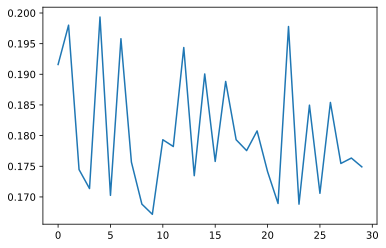

In [9]:
plt.plot(range(len(test_errs)), test_errs)

In [12]:
epsilon = 0.6
delta = epsilon * model.weight.detach().sign()

# Testing error on adversarial sample 
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X = X.to(torch.float32)
#         tmp = ((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)
        yp = model(X-((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)).squeeze(-1)
#         print(yp)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model_robust, delta[None,None,:,:]))

(0.2478717523493643, 0.549742345277152)


In [18]:
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        yp = model(X.view(X.shape[0], -1).to(torch.float32))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


model_robust = nn.Linear(num_input, 1)
opt = optim.SGD(model_robust.parameters(), lr=1e-2)
epsilon = 3.9
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(30):
    train_err, train_loss = epoch_robust(train_loader, model_robust, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model_robust, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")    

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.293529	0.806069	0.247872	0.644973
0.286149	0.803669	0.247872	0.664619
0.288802	0.803683	0.247872	0.696422
0.288554	0.804318	0.247872	0.638510
0.288222	0.803294	0.247872	0.770197
0.286950	0.803609	0.247872	0.658606
0.286840	0.803825	0.247872	0.630681
0.286591	0.803656	0.247872	0.664426
0.286508	0.803538	0.247872	0.735390
0.287310	0.803324	0.247872	0.668822
0.287061	0.803982	0.247872	0.775824
0.288277	0.804414	0.247872	0.726752
0.287365	0.803117	0.247872	0.661119
0.288194	0.803308	0.247872	0.669231
0.287171	0.803786	0.582863	1.313156
0.287697	0.803348	0.247872	0.695048
0.286010	0.803506	0.247872	0.782562
0.288167	0.803820	0.247872	0.817248
0.288249	0.803999	0.392924	1.245911
0.287365	0.803343	0.247872	0.860031
0.286453	0.803519	0.247872	0.642522
0.286646	0.802740	0.783416	1.302488
0.287835	0.803361	0.247872	0.745707
0.287254	0.803845	0.247872	0.660339
0.287780	0.803759	0.247872	0.771816
0.287973	0.803369	0.247872	0.654911
0.28

In [11]:
# model_robust = torch.load("./models/{}_lr_model_ro_standard.pth".format(data_name))
# torch.save(model_robust, "./models/{}_lr_model.pth".format(data_name))
torch.save(model_robust, "./models/{}_lr_model_ro_standard.pth".format(data_name))


In [18]:
data_name

'adult'

In [24]:
# Recourse Method 2
import Recourse_Methods.Generative_Model.model as model_vae
from numpy import linalg as LA

# Second class of counter-factual explanation methods         
class CCHVAE:

    def __init__(self, classifier, model_vae, target_threshold: float = 0,
                 n_search_samples: int = 10000, p_norm: int = 1,
                 step: float = 0.05, max_iter: int = 1000, clamp: bool = True):
        
        super().__init__()
        self.classifier = classifier
        self.generative_model = model_vae
        self.n_search_samples = n_search_samples
        self.p_norm = p_norm
        self.step = step
        self.max_iter = max_iter
        self.clamp = clamp
        self.target_treshold = target_threshold

    def hyper_sphere_coordindates(self, instance, high, low):
    
        """
        :param n_search_samples: int > 0
        :param instance: numpy input point array
        :param high: float>= 0, h>l; upper bound
        :param low: float>= 0, l<h; lower bound
        :param p: float>= 1; norm
        :return: candidate counterfactuals & distances
        """
    
        delta_instance = np.random.randn(self.n_search_samples, instance.shape[1])
        dist = np.random.rand(self.n_search_samples) * (high - low) + low  # length range [l, h)
        norm_p = LA.norm(delta_instance, ord=self.p_norm, axis=1)
        d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
        delta_instance = np.multiply(delta_instance, d_norm)
        candidate_counterfactuals = instance + delta_instance
    
        return candidate_counterfactuals, dist

    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
        :param instance: np array
        :return: best CE
        """  #

        # init step size for growing the sphere
        low = 0
        high = low + self.step

        # counter
        count = 0
        counter_step = 1
        query_instance = query_instance.detach().numpy()

        # get predicted label of instance
        self.classifier.eval()
        instance_label = 1 - target_class
        # vectorize z
        z = self.generative_model.encode_csearch(torch.from_numpy(query_instance).float()).detach().numpy()
        z_rep = np.repeat(z.reshape(1, -1), self.n_search_samples, axis=0)
        y_cand = []
        while True:
            count = count + counter_step
            if count > self.max_iter:
                candidate_counterfactual_star = np.empty(query_instance.shape[0], )
                candidate_counterfactual_star[:] = np.nan
                distance_star = -1
                print('No CE found')
                break

            # STEP 1 -- SAMPLE POINTS on hypersphere around instance
            latent_neighbourhood, _ = CCHVAE.hyper_sphere_coordindates(self, z_rep, high, low)
            
#             print("-->> ", latent_neighbourhood)
            x_ce = self.generative_model.decode_csearch(torch.from_numpy(latent_neighbourhood).float()).detach().numpy()
            
            
            # why do we have this?
            if self.clamp:
                x_ce = x_ce.clip(-4, 4)

            # STEP 2 -- COMPUTE l1 & l2 norms
            if self.p_norm == 1:
                distances = np.abs((x_ce - query_instance)).sum(axis=1)
            elif self.p_norm == 2:
                distances = LA.norm(x_ce - query_instance, axis=1)
            else:
                print('Distance not defined yet')
            
            # counterfactual labels
#             print(self.classifier(torch.from_numpy(x_ce).float()).detach().numpy())
            y_cand.extend([int(i[0]) for i in self.classifier(torch.from_numpy(x_ce).float()).detach().numpy() > 0])
            y_candidate = torch.stack([torch.tensor([int(i[0])]) for i in self.classifier(torch.from_numpy(x_ce).float()).detach().numpy() > 0])
            
            print("Y_Cands : ", self.classifier(torch.from_numpy(x_ce).float()).detach().numpy().mean())
            indeces = np.where(y_candidate != instance_label)[0]
#             print("Indeces : ", indeces)
            candidate_counterfactuals = x_ce[indeces]
            candidate_dist = distances[indeces]
            
            if len(candidate_dist) == 0:  # no candidate found & push search range outside
                low = high
                high = low + self.step
            elif len(candidate_dist) > 0:  # certain candidates generated
                min_index = np.argmin(candidate_dist)
                candidate_counterfactual_star = candidate_counterfactuals[min_index]
                distance_star = np.abs(candidate_counterfactual_star - query_instance).sum()
                break

        return y_cand, torch.tensor(candidate_counterfactual_star), torch.tensor(distance_star)
#         return  torch.tensor(distance_star)     
    
    
    

In [25]:
def _get_input_subset(model_sub, inputs: torch.tensor,
                      subset_size: int = 100,
                      decision_threshold: float = 0) -> torch.tensor:
    
    """
    Get negatively classified inputs & return their predictions
    """
    
    yhat = (model_sub(inputs) > decision_threshold) * 1
    print(model_sub(inputs))
    check = (model_sub(inputs) < decision_threshold).detach().numpy()
    selected_indices = np.where(check)[0]
    input_subset = inputs[selected_indices]
    predicted_label_subset = yhat[selected_indices]
#     return input_subset, predicted_label_subset
    return input_subset[0:subset_size], predicted_label_subset[0:subset_size] #[0:subset_size] #[0:subset_size]

In [40]:
# Load the VAEs

vae_path = "../Recourse_Methods/Generative_Model/Saved_Models/"

input_size = dataset_train.get_number_of_features()

vae_model = model_vae.VAE_model(input_size,
                                data_meta_info['activFun'],
                                data_meta_info['d'],
                                data_meta_info['H1'],
                                data_meta_info['H2'])

data_meta_info["vae_path"] = vae_path + f"vae_{data_name}.pt"
print(data_meta_info["vae_path"])

vae_model.load_state_dict(torch.load(data_meta_info["vae_path"]))
        
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=True)
        
trainloader = DataLoader(dataset_train,
                         batch_size=data_meta_info["n_starting_instances"],
                         shuffle=True)


# This method makes the "Manifold assumption" and uses random search in latent space
# cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.3, max_iter=10000, target_threshold=0)
# cchvae_r = CCHVAE(classifier=model_robust, model_vae=vae_model, step=109.5, max_iter=10000, target_threshold=0)

# cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)
# cchvae2 = CCHVAE(classifier=model_robust, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)

### Plot 1 : Box plot for baseline and robust models for distance, and validity. 

# inputs = torch.stack([j for i in test_loader for j in torch.unbind(i[0].to(torch.float32))][:200])






../Recourse_Methods/Generative_Model/Saved_Models/vae_adult.pt


In [28]:
cchvae_r = CCHVAE(classifier=model_robust, model_vae=vae_model, step=0.3, max_iter=20000, target_threshold=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 100
testloader = DataLoader(dataset_train,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))

distances_cchave_r = []
for i in range(len(inputs)):
    if i%10 == 0:
        print("Gotten {} done...".format(i))
    y_val, ctr_cfe, ctr_val,  = cchvae_r.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 )
    if ctr_val.item() > 0:
        distances_cchave_r.append([ctr_cfe, ctr_val])
        
        

tensor([[-1.1558],
        [-1.6180],
        [-0.7056],
        ...,
        [-0.6485],
        [-0.7130],
        [-1.5719]], grad_fn=<AddmmBackward0>)
torch.Size([100, 13])
tensor([[ 0.7897,  0.7526,  2.2958, -0.1466,  5.3812,  0.7500, -1.4356, -1.6750,
          0.9366, -1.0983,  0.8382,  0.3998,  0.3088]])
Gotten 0 done...
Y_Cands :  -2.1128433
Y_Cands :  -2.113229
Y_Cands :  -2.1132104
Y_Cands :  -2.113609
Y_Cands :  -2.1143858
Y_Cands :  -2.1143754
Y_Cands :  -2.11553
Y_Cands :  -2.115441
Y_Cands :  -2.117215
Y_Cands :  -2.1174312
Y_Cands :  -2.1174448
Y_Cands :  -2.1192255
Y_Cands :  -2.1180072
Y_Cands :  -2.11762
Y_Cands :  -2.119265
Y_Cands :  -2.1197224
Y_Cands :  -2.1145155
Y_Cands :  -2.1179497
Y_Cands :  -2.1150944
Y_Cands :  -2.1115856
Y_Cands :  -2.1100736
Y_Cands :  -2.112889
Y_Cands :  -2.1085281
Y_Cands :  -2.1013124
Y_Cands :  -2.1057014
Y_Cands :  -2.100221
Y_Cands :  -2.1061776
Y_Cands :  -2.097229
Y_Cands :  -2.0929446
Y_Cands :  -2.0925028
Y_Cands :  -2.087356
Y

Y_Cands :  -1.4321481
Y_Cands :  -1.4234049
Y_Cands :  -1.4221216
Y_Cands :  -1.4188584
Y_Cands :  -1.4151375
Y_Cands :  -1.4113364
Y_Cands :  -1.406456
Y_Cands :  -1.401587
Y_Cands :  -1.4046037
Y_Cands :  -1.3975637
Y_Cands :  -1.7387573
Y_Cands :  -1.7384624
Y_Cands :  -1.7377166
Y_Cands :  -1.7363902
Y_Cands :  -1.7346388
Y_Cands :  -1.7331387
Y_Cands :  -1.7302926
Y_Cands :  -1.7278719
Y_Cands :  -1.7256051
Y_Cands :  -1.7238513
Y_Cands :  -1.7200569
Y_Cands :  -1.7151971
Y_Cands :  -1.710101
Y_Cands :  -1.7088339
Y_Cands :  -1.7039176
Y_Cands :  -1.6989468
Y_Cands :  -1.6953574
Y_Cands :  -1.6907697
Y_Cands :  -1.682961
Y_Cands :  -1.6784332
Y_Cands :  -1.6774728
Y_Cands :  -1.6708118
Y_Cands :  -1.6656238
Y_Cands :  -1.6622328
Y_Cands :  -1.6596172
Y_Cands :  -1.648462
Y_Cands :  -1.6484455
Y_Cands :  -1.6401359
Y_Cands :  -1.6326934
Y_Cands :  -1.6317502
Y_Cands :  -1.6268506
Y_Cands :  -1.6208904
Y_Cands :  -1.7509093
Y_Cands :  -1.7510968
Y_Cands :  -1.7510176
Y_Cands :  -1.7

Y_Cands :  -1.4010292
Y_Cands :  -1.3967987
Y_Cands :  -1.3962938
Y_Cands :  -1.3934839
Y_Cands :  -1.3836808
Y_Cands :  -1.3881032
Y_Cands :  -0.70580983
Y_Cands :  -0.70571274
Y_Cands :  -0.7064319
Y_Cands :  -0.7069499
Y_Cands :  -0.7064554
Y_Cands :  -0.70582694
Y_Cands :  -0.7062063
Y_Cands :  -0.7086488
Y_Cands :  -0.70686024
Y_Cands :  -0.71082443
Y_Cands :  -0.708423
Y_Cands :  -0.7447329
Y_Cands :  -0.74540097
Y_Cands :  -0.7455445
Y_Cands :  -0.7457061
Y_Cands :  -0.74706537
Y_Cands :  -0.74722147
Y_Cands :  -0.7464376
Y_Cands :  -0.7474538
Y_Cands :  -0.75008726
Y_Cands :  -0.7483724
Y_Cands :  -0.7508935
Y_Cands :  -0.7515906
Y_Cands :  -0.7538684
Y_Cands :  -0.7146627
Y_Cands :  -0.71517295
Y_Cands :  -0.7151421
Y_Cands :  -0.71537197
Y_Cands :  -0.7162473
Y_Cands :  -0.7164834
Y_Cands :  -0.71649003
Y_Cands :  -0.71804875
Y_Cands :  -0.71849984
Y_Cands :  -0.7196108
Y_Cands :  -0.71887696
Y_Cands :  -0.72420335
Y_Cands :  -0.72072405
Y_Cands :  -0.7122723
Y_Cands :  -0.71

Y_Cands :  -1.4067972
Y_Cands :  -1.4102021
Y_Cands :  -1.3973819
Y_Cands :  -1.3976327
Y_Cands :  -1.3919494
Y_Cands :  -1.5337285
Y_Cands :  -1.5334426
Y_Cands :  -1.5319101
Y_Cands :  -1.5307711
Y_Cands :  -1.5293975
Y_Cands :  -1.527857
Y_Cands :  -1.524667
Y_Cands :  -1.5228848
Y_Cands :  -1.5207604
Y_Cands :  -1.5145348
Y_Cands :  -1.5120852
Y_Cands :  -1.5112443
Y_Cands :  -1.5059898
Y_Cands :  -1.5036076
Y_Cands :  -1.4981896
Y_Cands :  -1.4921612
Y_Cands :  -1.4904971
Y_Cands :  -1.4808866
Y_Cands :  -1.4782723
Y_Cands :  -1.4753367
Y_Cands :  -1.4724174
Y_Cands :  -1.4693133
Y_Cands :  -1.4630393
Y_Cands :  -1.4593332
Y_Cands :  -1.4526101
Y_Cands :  -1.450832
Y_Cands :  -1.4414222
Y_Cands :  -1.4397153
Y_Cands :  -0.72687113
Y_Cands :  -0.72733885
Y_Cands :  -0.7271443
Y_Cands :  -0.72647434
Y_Cands :  -0.7284056
Y_Cands :  -0.72867656
Y_Cands :  -0.72944194
Y_Cands :  -0.7297586
Y_Cands :  -0.73002106
Y_Cands :  -0.7301774
Y_Cands :  -0.7309457
Y_Cands :  -0.7321052
Y_Cands

Y_Cands :  -1.4647712
Y_Cands :  -1.4626486
Y_Cands :  -1.4587533
Y_Cands :  -1.4548581
Y_Cands :  -1.4527144
Y_Cands :  -1.4522092
Y_Cands :  -1.4462098
Y_Cands :  -1.4423656
Y_Cands :  -1.4407682
Y_Cands :  -1.4331527
Y_Cands :  -1.4305909
Y_Cands :  -1.4293292
Y_Cands :  -1.4245472
Y_Cands :  -1.4221103
Y_Cands :  -1.4162108
Y_Cands :  -1.409767
Y_Cands :  -1.4071541
Y_Cands :  -1.4065729
Y_Cands :  -1.4297475
Y_Cands :  -1.4297997
Y_Cands :  -1.4282062
Y_Cands :  -1.427128
Y_Cands :  -1.4262775
Y_Cands :  -1.4238671
Y_Cands :  -1.4221052
Y_Cands :  -1.4193878
Y_Cands :  -1.4174113
Y_Cands :  -1.415822
Y_Cands :  -1.4094362
Y_Cands :  -1.4053037
Y_Cands :  -1.4063101
Y_Cands :  -1.4004091
Y_Cands :  -1.39724
Y_Cands :  -1.3971049
Y_Cands :  -1.3905567
Y_Cands :  -1.3876406
Y_Cands :  -1.3860984
Y_Cands :  -1.3823243
Y_Cands :  -1.3797675
Y_Cands :  -1.3688805
Y_Cands :  -0.7237535
Y_Cands :  -0.7239921
Y_Cands :  -0.7237318
Y_Cands :  -0.72447664
Y_Cands :  -0.726491
Y_Cands :  -0.7

Y_Cands :  -0.72276473
Y_Cands :  -0.9475425
Y_Cands :  -0.94725645
Y_Cands :  -0.9478697
Y_Cands :  -0.94780624
Y_Cands :  -0.9481539
Y_Cands :  -0.9493666
Y_Cands :  -0.9486436
Y_Cands :  -0.9493664
Y_Cands :  -0.9496752
Y_Cands :  -0.9506756
Y_Cands :  -0.94783455
Y_Cands :  -0.9531253
Y_Cands :  -0.950841
Y_Cands :  -0.9494627
Y_Cands :  -0.9436982
Y_Cands :  -0.95068437
Y_Cands :  -0.9491287
Y_Cands :  -0.9899879
Y_Cands :  -0.9901316
Y_Cands :  -0.9892318
Y_Cands :  -0.98970276
Y_Cands :  -0.99021834
Y_Cands :  -0.9898367
Y_Cands :  -0.9892508
Y_Cands :  -0.9900592
Y_Cands :  -0.9914777
Y_Cands :  -0.9891829
Y_Cands :  -0.99117976
Y_Cands :  -0.9889456
Y_Cands :  -0.9924353
Y_Cands :  -0.9892847
Y_Cands :  -0.98678356
Y_Cands :  -0.99185354
Y_Cands :  -0.98664767
Y_Cands :  -1.4494162
Y_Cands :  -1.4492406
Y_Cands :  -1.4484531
Y_Cands :  -1.4466107
Y_Cands :  -1.444441
Y_Cands :  -1.4429201
Y_Cands :  -1.4411213
Y_Cands :  -1.438616
Y_Cands :  -1.4359026
Y_Cands :  -1.4344326
Y_

In [36]:
distances_cchave_r = [i.item() for i in distances_cchave_r]

In [39]:
sum(distances_cchave_r)/len(distances_cchave_r)

15.71680848121643

In [ ]:
cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.3, max_iter=10000, target_threshold=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 100
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))

distances_cchave = []
for i in range(len(inputs)):
    if i%10 == 0:
        print("Gotten {} done...".format(i))
    y_pred, ctr_cfe, ctr_val,  = cchvae.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 )
    if ctr_val.item() > 0:
        distances_cchave.append([ctr_cfe, ctr_val])
        
# distances_cchave = [cchvae.generate_counterfactuals(
#                     query_instance= inputs[i].reshape(1, -1),
#                     target_class= 1 ).item() for i in range(subset_size)]
# for i in range(subset_size):
#     print("Processing...", i)
#     vals = cchvae.generate_counterfactuals(
#                     query_instance= inputs[i].reshape(1, -1),
#                     target_class= 1 ).item()
#     print(vals)


# print(epoch_adv(test_loader, model, delta[None,None,:,:]))


tensor([[-5.1400],
        [-4.4543],
        [ 1.3127],
        ...,
        [-1.4898],
        [-3.3359],
        [ 0.8341]], grad_fn=<AddmmBackward0>)
torch.Size([100, 13])
tensor([[-0.8682,  0.0661, -0.4451, -0.1476, -0.2200, -1.7371,  0.6828,  0.6025,
          0.9271,  0.9114,  0.8393, -2.4053,  0.3074]])
Gotten 0 done...
Y_Cands :  -4.4730864
Y_Cands :  -4.4707026
Y_Cands :  -4.467215
Y_Cands :  -4.4612603
Y_Cands :  -4.458259
Y_Cands :  -4.4497766
Y_Cands :  -4.441764
Y_Cands :  -4.4349194
Y_Cands :  -4.423503
Y_Cands :  -4.4178905
Y_Cands :  -4.4004188
Y_Cands :  -4.3908286
Y_Cands :  -4.387602
Y_Cands :  -4.3748665
Y_Cands :  -4.3631024
Y_Cands :  -4.3554897
Y_Cands :  -4.3429217
Y_Cands :  -4.3445396
Y_Cands :  -4.321928
Y_Cands :  -4.2869425
Y_Cands :  -4.310768
Y_Cands :  -4.2875915
Y_Cands :  -4.2827144
Y_Cands :  -4.2712893
Y_Cands :  -4.2620816
Y_Cands :  -4.268484
Y_Cands :  -4.566043
Y_Cands :  -4.563152
Y_Cands :  -4.563494
Y_Cands :  -4.559646
Y_Cands :  -4.5530405


Y_Cands :  -5.579701
Y_Cands :  -5.548625
Y_Cands :  -5.548776
Y_Cands :  -5.5177827
Y_Cands :  -5.518508
Y_Cands :  -5.4857774
Y_Cands :  -5.490724
Y_Cands :  -5.481502
Y_Cands :  -5.4508405
Y_Cands :  -5.434422
Y_Cands :  -5.3991523
Y_Cands :  -5.404341
Y_Cands :  -5.410328
Y_Cands :  -5.374016
Y_Cands :  -5.3635616
Y_Cands :  -5.3267655
Y_Cands :  -5.317384
Y_Cands :  -5.2881255
Y_Cands :  -5.295716
Y_Cands :  -4.35922
Y_Cands :  -4.356246
Y_Cands :  -4.3547244
Y_Cands :  -4.348516
Y_Cands :  -4.3453135
Y_Cands :  -4.3384156
Y_Cands :  -4.3353634
Y_Cands :  -4.329196
Y_Cands :  -4.316229
Y_Cands :  -4.3158493
Y_Cands :  -4.297815
Y_Cands :  -4.3067007
Y_Cands :  -4.279021
Y_Cands :  -4.2636514
Y_Cands :  -4.2557945
Y_Cands :  -4.243386
Y_Cands :  -4.2446003
Y_Cands :  -4.235266
Y_Cands :  -4.2341924
Y_Cands :  -4.229379
Y_Cands :  -4.219663
Y_Cands :  -4.201013
Y_Cands :  -4.2119164
Y_Cands :  -1.8066223
Y_Cands :  -1.8069726
Y_Cands :  -1.8097371
Y_Cands :  -1.8158475
Y_Cands :  -1

Y_Cands :  -4.4009523
Y_Cands :  -4.3872056
Y_Cands :  -4.363794
Y_Cands :  -4.3669724
Y_Cands :  -4.344425
Y_Cands :  -4.3401136
Y_Cands :  -4.33623
Y_Cands :  -4.3095193
Y_Cands :  -4.305689
Y_Cands :  -4.299432
Y_Cands :  -4.305783
Y_Cands :  -4.284829
Y_Cands :  -4.2557025
Y_Cands :  -4.278371
Y_Cands :  -4.25375
Y_Cands :  -4.5163226
Y_Cands :  -4.5152335
Y_Cands :  -4.5140877
Y_Cands :  -4.5074525
Y_Cands :  -4.5029135
Y_Cands :  -4.4962673
Y_Cands :  -4.4864626
Y_Cands :  -4.473701
Y_Cands :  -4.4740467
Y_Cands :  -4.4582853
Y_Cands :  -4.4491873
Y_Cands :  -4.4286547
Y_Cands :  -4.432723
Y_Cands :  -4.421098
Y_Cands :  -4.401821
Y_Cands :  -4.3905272
Y_Cands :  -4.3753524
Y_Cands :  -4.354582
Y_Cands :  -4.357719
Y_Cands :  -4.351174
Y_Cands :  -4.350212
Y_Cands :  -4.324424
Y_Cands :  -4.3336463
Y_Cands :  -4.318412
Y_Cands :  -4.6418786
Y_Cands :  -4.639229
Y_Cands :  -4.638017
Y_Cands :  -4.6333375
Y_Cands :  -4.626349
Y_Cands :  -4.6225486
Y_Cands :  -4.614042
Y_Cands :  -4

Y_Cands :  -4.499875
Y_Cands :  -4.4902787
Y_Cands :  -4.4803705
Y_Cands :  -4.4800854
Y_Cands :  -4.46058
Y_Cands :  -4.4416065
Y_Cands :  -4.4512997
Y_Cands :  -4.43125
Y_Cands :  -4.4122767
Y_Cands :  -4.4207873
Y_Cands :  -4.411015
Y_Cands :  -4.3759327
Y_Cands :  -4.385933
Y_Cands :  -4.350285
Y_Cands :  -4.6989236
Y_Cands :  -4.6970224
Y_Cands :  -4.692439
Y_Cands :  -4.6891828
Y_Cands :  -4.6851892
Y_Cands :  -4.673812
Y_Cands :  -4.6675553
Y_Cands :  -4.6579328
Y_Cands :  -4.6485314
Y_Cands :  -4.62664
Y_Cands :  -4.628134
Y_Cands :  -4.6116867
Y_Cands :  -4.600514
Y_Cands :  -4.588868
Y_Cands :  -4.580507
Y_Cands :  -4.5718603
Y_Cands :  -4.547755
Y_Cands :  -4.5302877
Y_Cands :  -4.5242386
Y_Cands :  -4.524176
Y_Cands :  -4.502166
Y_Cands :  -4.4929113
Y_Cands :  -4.4876246
Y_Cands :  -4.4794717
Y_Cands :  -4.4632525
Y_Cands :  -4.637224
Y_Cands :  -4.636647
Y_Cands :  -4.6319194
Y_Cands :  -4.6266193
Y_Cands :  -4.62121
Y_Cands :  -4.6174827
Y_Cands :  -4.605381
Y_Cands :  -

In [126]:
distances_cchave = [i[1] for i in distances_cchave]

In [127]:
sum(distances_cchave)/len(distances_cchave)

tensor(16.0542)

In [55]:
cfe_base = [i[0] for i in distances_cchave]
cfe_base = [i[0] for i in distances_cchave_r]
distances_cchave = [i[1] for i in distances_cchave]
distances_cchave_r = [i[1] for i in distances_cchave_r]



In [82]:
import pickle as pkl
pkl.dump(distances_cchave_r, open("ro_cchvae_minmax_{}_.pkl".format(data_name), "wb"))
pkl.dump(distances_cchave, open("base_cchvae_minmax_{}_.pkl".format(data_name), "wb"))

sum(distances_cchave_r)/len(distances_cchave_r)


tensor(14.3080)

In [91]:
model_name = ["base"]*len(distances_cchave) + ["robust"]*len(distances_cchave_r) # + len(distance_scfe))
cost_vals = [i for i in distances_cchave] + [i for i in distances_cchave_r]

cchvae_data_df = pd.DataFrame(list(zip(cost_vals, model_name)), columns=["Cost", "Model"])
cchvae_data_df.to_csv("{}_cchvae_data_df.csv".format(data_name))



In [92]:
# cchvae_data_df = pd.read_csv("adult_cchvae.csv")
# del cchvae_data_df["Unnamed: 0"]

In [97]:
# Recourse Method -1 
import torch
import numpy as np
from torch import nn
import datetime


class SCFE:
    
    def __init__(self, classifier, target_threshold: float = 0, _lambda: float = 10.0,
                 lr: float = 0.1, max_iter: int = 500, t_max_min: float = 0.5,
                 step: float = 0.10, norm: int = 1, optimizer: str = 'adam'):
        
        super().__init__()
        self.model_classification = classifier
        self.lr = lr
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.t_max_min = t_max_min
        self.norm = norm
        self.sigmoid = nn.Sigmoid()
        self.target_thres = target_threshold
        self._lambda = _lambda
        self.step = step
    
    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
            query instance: the point to be explained
            target_class: Direction of the desired change. If target_class = 1, we aim to improve the score,
                if target_class = 0, we aim to decrese it (in classification and regression problems).
            _lambda: Lambda parameter (distance regularization) parameter of the problem
        """
        
        if target_class == 1:
            target_prediction = torch.tensor(1).float()
        else:
            target_prediction = torch.tensor(0).float()
        
        output = self._call_model(query_instance.reshape(1, -1))
        output = self._call_model(query_instance)
        
        cf = query_instance.clone().requires_grad_(True)
        
        if self.optimizer == 'adam':
            optim = torch.optim.Adam([cf], self.lr)
        else:
            optim = torch.optim.RMSprop([cf], self.lr)
        
        # Timer
        t0 = datetime.datetime.now()
        t_max = datetime.timedelta(minutes=self.t_max_min)
        
        counterfactuals = []
        while not self._check_cf_valid(output, target_class):
#             print("in...")
            iter = 0
            distances = []
            all_loss = []
            while not self._check_cf_valid(output, target_class) and iter < self.max_iter:
                cf.requires_grad = True
                total_loss, loss_distance = self.compute_loss(self._lambda, cf,
                                                              query_instance,
                                                              target_prediction)
                optim.zero_grad()
                total_loss.backward(retain_graph=True)
                optim.step()
                
                output = self._call_model(cf)
                
                if self._check_cf_valid(output, target_class):
                    counterfactuals.append(cf.detach())
                    distances.append(loss_distance.clone().detach())
                    all_loss.append(total_loss.detach())
                
                iter = iter + 1
            
            output = self._call_model(cf).reshape(1, -1).detach()
            if datetime.datetime.now() - t0 > t_max:
                break

            if self.step == 0.0:  # Don't search over lambdas
                break
            else:
                self._lambda -= self.step

        if not len(counterfactuals):
            print('No CE found')
            cf.detach_()
            return torch.tensor(-1.0)
        
        # Choose the nearest counterfactual
        counterfactuals = torch.stack(counterfactuals)
        distances = torch.stack(distances)
        distances = distances.detach()
        index = torch.argmin(distances)
        counterfactuals = counterfactuals.detach()

        ce_star = counterfactuals[index]
        distance_star = distances[index]
        
        
#         return ce_star, distance_star
        return distance_star

    
    def compute_loss(self, _lambda: float, cf_candidate: torch.tensor, original_instance: torch.tensor,
                     target: torch.tensor) -> torch.tensor:
        output = self._call_model(cf_candidate)
        # classification loss
        bce_loss = nn.BCEWithLogitsLoss()
#         print("Testing code : " , output, target)
        loss_classification = bce_loss(output, target)
        # distance loss
        loss_distance = torch.norm((cf_candidate - original_instance), self.norm)
        # full loss
        total_loss = loss_classification + _lambda * loss_distance
        return total_loss, loss_distance

    def _call_model(self, cf_candidate):
        output = self.model_classification(cf_candidate)[0]
#         print(output)
        return output

    def _check_cf_valid(self, output, target_class):
        """ Check if the output constitutes a sufficient CF-example.
            target_class = 1 in general means that we aim to improve the score,
            whereas for target_class = 0 we aim to decrese it.
        """
        if target_class == 1:
            check = output >= self.target_thres
            return check
        else:
            check = output <= self.target_thres
            return check
        

In [95]:
scfe = SCFE(classifier=model, lr=1e-3, _lambda=0.00, step=0.00, max_iter=10000, target_threshold=0)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 200
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model, inputs, subset_size, decision_threshold=0)

cost_scfe = []
for i in range(len(inputs)):
    if i%100 == 0:
        print("Gotten {} done...".format(i))
    val_scfe = scfe.generate_counterfactuals(
                    query_instance=inputs[i],
                    target_class=1)
    if val_scfe.item() > 0:
        cost_scfe.append(val_scfe)
        

tensor([[-6.9910],
        [-0.8539],
        [-1.9934],
        ...,
        [-2.2990],
        [-2.7796],
        [ 0.8908]], grad_fn=<AddmmBackward0>)
Gotten 0 done...
Gotten 100 done...
Gotten 200 done...
Gotten 300 done...
Gotten 400 done...
Gotten 500 done...
Gotten 600 done...
Gotten 700 done...
Gotten 800 done...
Gotten 900 done...


In [100]:
scfe_r = SCFE(classifier=model_robust, lr=1e-3, _lambda=0.00, step=0.00, max_iter=10000, target_threshold=0)

testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)

cost_scfe_r = []
for i in range(len(inputs)):
    if i%100 == 0:
        print("Gotten {} done...".format(i))
    val_scfe = scfe_r.generate_counterfactuals(
                    query_instance=inputs[i],
                    target_class=1)
    if val_scfe.item() > 0:
        cost_scfe_r.append(val_scfe)

tensor([[-4.3380],
        [-0.5300],
        [-1.8543],
        ...,
        [-1.6476],
        [-0.9036],
        [-0.4300]], grad_fn=<AddmmBackward0>)
Gotten 0 done...
Gotten 100 done...
Gotten 200 done...
Gotten 300 done...
Gotten 400 done...
Gotten 500 done...
Gotten 600 done...
Gotten 700 done...
Gotten 800 done...
Gotten 900 done...
Gotten 1000 done...


In [101]:
model_name = ["base"]*len(cost_scfe) + ["robust"]*len(cost_scfe_r) # + len(distance_scfe))
cost_vals = [i for i in cost_scfe] + [i for i in cost_scfe_r]

scfe_data_df = pd.DataFrame(list(zip(cost_vals, model_name)), columns=["Cost", "Model"])
scfe_data_df.to_csv("{}_scfe_data_df.csv".format(data_name))


# scfe_data_df = pd.read_csv("{}_scfe_data_df.csv".format(data_name), index_col=False)



In [102]:
vals_base_scfe = scfe_data_df[scfe_data_df["Model"] == "base"]["Cost"].values
vals_base_cchvae = cchvae_data_df[cchvae_data_df["Model"] == "base"]["Cost"].values

method_names = ["scfe"]*len(vals_base_scfe) + ["cchvae"]*len(vals_base_cchvae)
cost_values_base = list(vals_base_scfe) + list(vals_base_cchvae)



In [103]:
pd.DataFrame(list(zip(cost_values_base, method_names)), columns=["Cost", "Method"]).to_csv("base_cost_{}.csv".format(data_name))




In [104]:

vals_robust_scfe = scfe_data_df[scfe_data_df["Model"] == "robust"]["Cost"].values
vals_robust_cchvae = cchvae_data_df[cchvae_data_df["Model"] == "robust"]["Cost"].values

method_names = ["scfe"]*len(vals_robust_scfe) + ["cchvae"]*len(vals_robust_cchvae)
cost_values_robust = list(vals_robust_scfe) + list(vals_robust_cchvae)


pd.DataFrame(list(zip(cost_values_robust, method_names)), columns=["Cost", "Method"]).to_csv("robust_cost_{}.csv".format(data_name))



In [105]:
import os
import ipdb
import glob
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

processing .. scfe
processing .. cchvae
skyblue
processing .. scfe
processing .. cchvae
orange


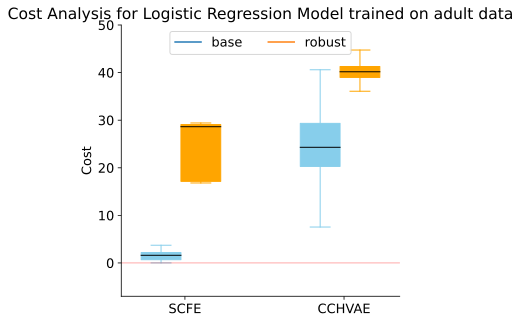

In [92]:

testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))
distances_cchave_r = [cchvae.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 ).item() for i in range(subset_size)]

print(epoch_adv(test_loader, model, delta[None,None,:,:]))

torch.Size([1200, 13])
tensor([[0.1370, 0.1511, 0.5333, 0.0000, 0.0000, 0.1939, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 0.0000, 1.0000]])


KeyboardInterrupt: 

In [ ]:
distances_cchave_r

In [ ]:
sum(distances_cchave)/len(distances_cchave)